In [23]:
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
# from crfseg import CRF
# from torchcrf import CRF
import torch.nn.functional as F
import tqdm as tqdm
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt

## Dataset with Glove

In [3]:
import os
import numpy as np
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    def __init__(self, data_dir, label_dict, glove_file, window_size=2, max_len_keyphrase=30):
        self.data_dir = data_dir
        self.txtfiles = []
        self.annfiles = []
        self.max_len_keyphrase = max_len_keyphrase
        self.label_dict = label_dict

        # Load GloVe embeddings
        self.word_to_index, self.embeddings = self.load_glove_embeddings(glove_file)

        for file in os.listdir(data_dir):
            if file.endswith(".txt"):
                self.txtfiles.append(file)

        self.keyphrases_with_context = []
        self.labels = []  # Store labels separately
        for i, txtfile in enumerate(self.txtfiles):
            sampleid = txtfile.split(".")[0]
            annfilename = sampleid + ".ann"
            with open(os.path.join(self.data_dir, annfilename), 'r') as file:
                ann = file.read()
            with open(os.path.join(self.data_dir, txtfile), 'r') as file:
                txt = file.read()
            offsets, tokenisedtxt = self.tokenise(txt)
            token_ids = [self.word_to_index.get(token, 0) for token in tokenisedtxt]  # Map tokens to indices
            for line in ann.split('\n'):
                if line == '':
                    continue
                words = line.split()
                if words[0][0] != 'T':
                    continue
                label = self.label_dict[words[1]]
                self.labels.append(label)  # Save the label
                ssofset = words[2]
                endoffset = words[3]
                start_index = 0
                for i in range(len(offsets)):
                    if offsets[i] >= int(ssofset):
                        start_index = i
                        break
                end_index = 0
                for i in range(len(offsets)):
                    if offsets[i] >= int(endoffset):
                        end_index = i
                        break
                mins = max(0, start_index - window_size)
                maxs = min(len(token_ids), end_index + window_size)
                tks = token_ids[mins:maxs]
                if len(tks) < max_len_keyphrase:
                    tks += [0] * (max_len_keyphrase - len(tks))  # Padding with zeros for shorter sequences
                self.keyphrases_with_context.append(tks)

    def tokenise(self, text):
        tokens = []
        starting_offsets = []
        current_token = ''
        offset = 0
        for char in text:
            if char == ' ':
                if current_token:
                    tokens.append(current_token.lower())
                    starting_offsets.append(offset - len(current_token))
                    current_token = ''
                offset += 1
            else:
                current_token += char
                offset += 1
        if current_token:
            tokens.append(current_token.lower())
            starting_offsets.append(offset - len(current_token))
        return starting_offsets, tokens

    def load_glove_embeddings(self, glove_file):
        word_to_index = {}
        embeddings = []
        with open(glove_file, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                values = line.split()
                word = values[0]
                embedding = np.array(values[1:], dtype='float32')
                word_to_index[word] = idx
                embeddings.append(embedding)
        return word_to_index, np.array(embeddings)

    def __len__(self):
        return len(self.keyphrases_with_context)

    def __getitem__(self, index):
        return self.keyphrases_with_context[index], self.labels[index]

    def collate_fn(self, batch):
        keyphrases = []
        labels = []
        for keyphrase, label in batch:
            keyphrases.append(torch.tensor(keyphrase))
            labels.append(torch.tensor(label))
        keyphrases = torch.stack(keyphrases)
        labels = torch.stack(labels)
        return keyphrases, labels


In [4]:
label_dict = {
    'Process' : 0,
    'Task' : 1,
    'Material' : 2,
}

In [7]:
glove = ['/Users/ashnadua/downloads/glove/glove.6B.50d.txt', '/Users/ashnadua/downloads/glove/glove.6B.100d.txt', '/Users/ashnadua/downloads/glove/glove.6B.200d.txt', '/Users/ashnadua/downloads/glove/glove.6B.300d.txt']
train_data = '../../scienceie2017_train/train2'
dev_data = "../../scienceie2017_dev/dev"
test_data = "../../semeval_articles_test"
batch_size = 32

## Stacked Learner

In [13]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

class StackedLearner:
    def __init__(self, base_classifiers, meta_classifier):
        # initialize base and meta classifiers
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier
    
    def fit_base_classifiers(self, X, y):
        # cross-validation
        skf = StratifiedKFold(n_splits=10)
        
        base_predictions = []
        for clf in self.base_classifiers:
            clf_base_predictions = []
            
            # 10-fold cross-validation
            for train_index, val_index in skf.split(X, y):
                X_train, X_val = X[train_index], X[val_index]
                y_train, _ = y[train_index], y[val_index]
                clf.fit(X_train, y_train)
                y_val_pred = clf.predict(X_val)
                clf_base_predictions.append(y_val_pred) 
            
            base_predictions.append(np.concatenate(clf_base_predictions))
        
        return np.array(base_predictions).T

    def fit_meta_classifier(self, base_predictions, y):
        self.meta_classifier.fit(base_predictions, y)
    
    def predict(self, X):
        # collect base predictions
        base_predictions = []
        for clf in self.base_classifiers:
            base_predictions.append(clf.predict(X))
        
        base_predictions = np.array(base_predictions).T
        
        # meta classifier to make final predictions
        return self.meta_classifier.predict(base_predictions)
    
    def compute_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)


In [16]:
from sklearn.metrics import classification_report

In [19]:
train_accuracies = []
dev_accuracies = []
test_accuracies = []

## Metrics

In [20]:
for glove_file_path in glove:
    print(glove_file_path)
    train_dataset = MyDataset(data_dir=train_data, label_dict=label_dict, glove_file=glove_file_path)
    dev_dataset = MyDataset(data_dir=dev_data, label_dict=label_dict, glove_file=glove_file_path)
    test_dataset = MyDataset(data_dir=test_data, label_dict=label_dict, glove_file=glove_file_path)

    X_train = np.array(train_dataset.keyphrases_with_context)
    y_train = np.array(train_dataset.labels)

    X_dev = np.array(dev_dataset.keyphrases_with_context)
    y_dev = np.array(dev_dataset.labels)

    X_test = np.array(test_dataset.keyphrases_with_context)
    y_test = np.array(test_dataset.labels)

    base_classifiers = [
        RandomForestClassifier(n_estimators=100),
        RandomForestClassifier(n_estimators=200),
        ExtraTreesClassifier(n_estimators=100),
        ExtraTreesClassifier(n_estimators=200),
        XGBClassifier()
    ]

    meta_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)
    stacked_learner = StackedLearner(base_classifiers, meta_classifier)
    base_predictions = stacked_learner.fit_base_classifiers(X_train, y_train)
    stacked_learner.fit_meta_classifier(base_predictions, y_train)

    y_pred_train = stacked_learner.predict(X_train)
    accuracy_train = stacked_learner.compute_accuracy(y_train, y_pred_train)
    print("Training Accuracy:", accuracy_train)
    print("Training Classification Report:")
    print(classification_report(y_train, y_pred_train))

    # Predict and compute accuracy for the development set
    y_pred_dev = stacked_learner.predict(X_dev)
    accuracy_dev = stacked_learner.compute_accuracy(y_dev, y_pred_dev)
    print("\nDevelopment Accuracy:", accuracy_dev)
    print("Development Classification Report:")
    print(classification_report(y_dev, y_pred_dev))

    # Predict and compute accuracy for the test set
    y_pred_test = stacked_learner.predict(X_test)
    accuracy_test = stacked_learner.compute_accuracy(y_test, y_pred_test)
    print("\nTest Accuracy:", accuracy_test)
    print("Test Classification Report:")
    print(classification_report(y_test, y_pred_test))

    train_accuracies.append(accuracy_train)
    dev_accuracies.append(accuracy_dev)
    test_accuracies.append(accuracy_test)

    print("\n\n")
    

/Users/ashnadua/downloads/glove/glove.6B.50d.txt
Training Accuracy: 0.8617052881758764
Training Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      2992
           1       0.98      0.72      0.83      1132
           2       0.87      0.89      0.88      2608

    accuracy                           0.86      6732
   macro avg       0.89      0.83      0.86      6732
weighted avg       0.87      0.86      0.86      6732


Development Accuracy: 0.5774526678141136
Development Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       458
           1       0.72      0.24      0.36       137
           2       0.66      0.61      0.63       567

    accuracy                           0.58      1162
   macro avg       0.62      0.50      0.52      1162
weighted avg       0.60      0.58      0.57      1162


Test Accuracy: 0.5243664717348928
Test Cl

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.8615567439096851
Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2992
           1       0.98      0.72      0.83      1132
           2       0.87      0.90      0.88      2608

    accuracy                           0.86      6732
   macro avg       0.89      0.83      0.86      6732
weighted avg       0.87      0.86      0.86      6732


Development Accuracy: 0.5783132530120482
Development Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       458
           1       0.72      0.24      0.36       137
           2       0.64      0.65      0.64       567

    accuracy                           0.58      1162
   macro avg       0.62      0.49      0.52      1162
weighted avg       0.59      0.58      0.57      1162


Test Accuracy: 0.5253411306042886
Test Classification Report:
              precision    r

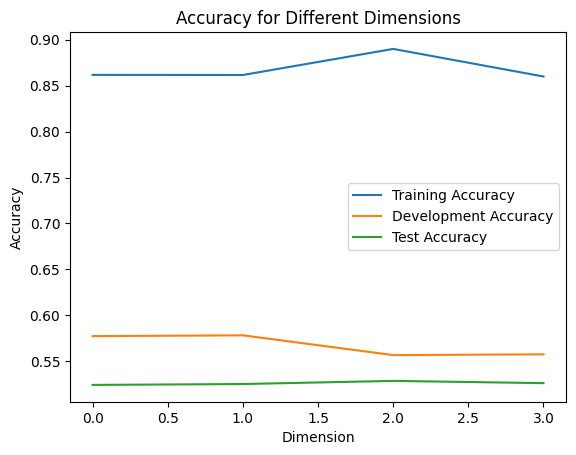

In [22]:
dimensions = list(range(len(glove)))  # Assuming glove is a list of dimensions
plt.plot(dimensions, train_accuracies, label='Training Accuracy')
plt.plot(dimensions, dev_accuracies, label='Development Accuracy')
plt.plot(dimensions, test_accuracies, label='Test Accuracy')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Dimensions')
plt.legend()
plt.show()